In [1]:
# Importing the lib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import seaborn as sns
from sklearn.model_selection import train_test_split,KFold

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train_original = pd.read_csv('train.csv')
test_original = pd.read_csv('test.csv')

In [4]:
y_train = train['amount_spent_per_room_night_scaled']

In [5]:
# drop un-necessary col
train.drop(['reservation_id','memberid'],axis=1,inplace=True)
test.drop(['reservation_id','memberid'],axis=1,inplace=True)

In [6]:
# Adding number of days stay in hotel
from datetime import date
days_train=[]
days_test=[]
for d1,d2 in zip(train['checkin_date'],train['checkout_date']):
    d1_years='20'+d1[6:]
    d2_years='20'+d2[6:]
    d1_mon = d1[3:5]
    d2_mon = d2[3:5]
    d1_day = d1[:2]
    d2_day= d2[:2]
    d1_ = date(int(d1_years),int(d1_mon),int(d1_day))
    d2_ = date(int(d2_years),int(d1_mon),int(d1_day))
    delta = d2_ - d1_
    days_train.append(delta.days)
train['no. of days']=days_train

for d1,d2 in zip(test['checkin_date'],test['checkout_date']):
    d1_years='20'+d1[6:]
    d2_years='20'+d2[6:]
    d1_mon = d1[3:5]
    d2_mon = d2[3:5]
    d1_day = d1[:2]
    d2_day= d2[:2]
    d1_ = date(int(d1_years),int(d1_mon),int(d1_day))
    d2_ = date(int(d2_years),int(d1_mon),int(d1_day))
    delta = d2_ - d1_
    days_test.append(delta.days)
test['no. of days']=days_test

In [7]:
# Extracting the months and year from the date col
import re
def extract_mo_yr(file,col_name):
    mo=[]
    yr=[]
    new_col_name_mo = col_name + '_month'
    new_col_name_yr = col_name + '_year'
    for each in file[col_name]:
        w=re.findall(r'\d+',each)
        mo.append(int(w[1]))
        yr.append(int(w[2]))
    file[new_col_name_mo]=mo
    file[new_col_name_yr]=yr
    file.drop(col_name,axis=1,inplace=True)

extract_mo_yr(train,'booking_date')
extract_mo_yr(train,'checkin_date')
extract_mo_yr(train,'checkout_date')
extract_mo_yr(test,'booking_date')
extract_mo_yr(test,'checkin_date')
extract_mo_yr(test,'checkout_date')

In [8]:
train.columns

Index(['channel_code', 'main_product_code', 'numberofadults',
       'numberofchildren', 'persontravellingid', 'resort_region_code',
       'resort_type_code', 'room_type_booked_code', 'roomnights',
       'season_holidayed_code', 'state_code_residence', 'state_code_resort',
       'total_pax', 'member_age_buckets', 'booking_type_code', 'cluster_code',
       'reservationstatusid_code', 'resort_id',
       'amount_spent_per_room_night_scaled', 'no. of days',
       'booking_date_month', 'booking_date_year', 'checkin_date_month',
       'checkin_date_year', 'checkout_date_month', 'checkout_date_year'],
      dtype='object')

In [9]:
train.dtypes

channel_code                            int64
main_product_code                       int64
numberofadults                          int64
numberofchildren                        int64
persontravellingid                      int64
resort_region_code                      int64
resort_type_code                        int64
room_type_booked_code                   int64
roomnights                              int64
season_holidayed_code                 float64
state_code_residence                  float64
state_code_resort                       int64
total_pax                               int64
member_age_buckets                     object
booking_type_code                       int64
cluster_code                           object
reservationstatusid_code               object
resort_id                              object
amount_spent_per_room_night_scaled    float64
no. of days                             int64
booking_date_month                      int64
booking_date_year                 

In [10]:
# converting categorial data into numerical

from sklearn.preprocessing import LabelEncoder

le_resort_id = LabelEncoder()
train['resort_id'] = le_resort_id.fit_transform(train['resort_id'])
test['resort_id'] = le_resort_id.fit_transform(test['resort_id'])

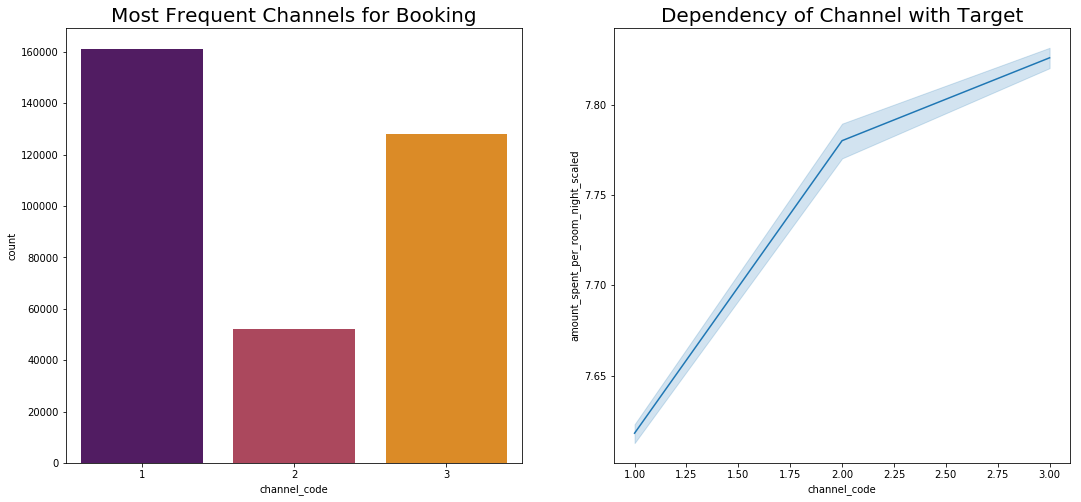

In [11]:
# analysis of channel code
# checking the count of channel code

plt.rcParams['figure.figsize'] = (18, 8)
plt.subplot(1, 2, 1)
sns.countplot(train['channel_code'], palette = 'inferno')
plt.title('Most Frequent Channels for Booking', fontsize = 20)

# checking dependency of channel code with target

plt.subplot(1, 2, 2)
sns.lineplot(train['channel_code'], y_train, palette = 'magma')
plt.title('Dependency of Channel with Target', fontsize = 20)

plt.show()

In [12]:
# as we can  see that dependency of channel 3 is high then 2 and then 1

# applying mean ecoding following the graph
# main product code 1 and 2 have huge impact, 3, 6, 7 have good impact and 4, 5 have very less impact
# replacing 4, 5 with 1
# replacing 3, 6, 7 with 2, and
# replacing 1, 2 with 3

train['main_product_code'].replace((1, 2, 3, 4, 5, 6, 7), (3, 3, 2, 1, 1, 2, 2), inplace = True)
test['main_product_code'].replace((1, 2, 3, 4, 5, 6, 7), (3, 3, 2, 1, 1, 2, 2), inplace = True)

# checking the values
test['main_product_code'].value_counts()

3    101361
2     37435
1      7969
Name: main_product_code, dtype: int64

In [13]:
# as we can see that there is a pattern which says that the spending score increases for no. of adults 1 to 10, but it is very confusing for 10-30 and vey high for 32
# so we can make 3 groups no. of adults 1-10, 11-20, 21+

def groups(numberofadults):
  if numberofadults <= 10:
    return 1
  if numberofadults <= 20 and numberofadults > 10:
    return 2
  else:
    return 3


train['numberofadults'] = train.apply(lambda x: groups(x['numberofadults']), axis = 1)
test['numberofadults'] = test.apply(lambda x: groups(x['numberofadults']), axis = 1)

print(train['numberofadults'].value_counts())
print(test['numberofadults'].value_counts())

1    338909
2      2361
3       154
Name: numberofadults, dtype: int64
1    145673
2      1011
3        81
Name: numberofadults, dtype: int64


In [14]:
# as we can see that there is a pattern which says that the spending score increases for no. of children 1 to 10, but it is very confusing for 10-30 and vey high for 32
# so we can make 3 groups no. of adults 1-10, 11-20, 21+

def groups(numberofchildren):
  if numberofchildren <= 4:
    return 1
  if numberofchildren <= 8 and numberofchildren > 4:
    return 2
  else:
    return 3


train['numberofchildren'] = train.apply(lambda x: groups(x['numberofchildren']), axis = 1)
test['numberofchildren'] = test.apply(lambda x: groups(x['numberofchildren']), axis = 1)

print(train['numberofchildren'].value_counts())
print(test['numberofchildren'].value_counts())

1    340975
2       432
3        17
Name: numberofchildren, dtype: int64
1    146564
2       192
3         9
Name: numberofchildren, dtype: int64


In [15]:
# as from the above graph it is clearly visible that region 1 has huge impact, region 2 has good impact and region 3 has low impact onn amount spent 
# so let's do target encoding

train["resort_region_code"].replace((1, 2, 3), (3, 2, 1), inplace = True)
test["resort_region_code"].replace((1, 2, 3), (3, 2, 1), inplace = True)

# checking the values 
print(train['resort_region_code'].value_counts())
print(test['resort_region_code'].value_counts())

3    143790
2    131361
1     66273
Name: resort_region_code, dtype: int64
3    61961
2    55997
1    28807
Name: resort_region_code, dtype: int64


In [16]:
# as from the above graph it is clearly visible that all the seven types of resort different weightage
# so let's do target encoding resort type 1, 5 have huge impact, resort no. 4, 2, 5 have good impact and resort type 7 and 3 have poor impact
# encoding 5 and 1 as 3
# encoding 4, 2, 6 as 2
# encoding 7 and 3 as 1

train["resort_type_code"].replace((0, 1, 2, 3, 4, 5, 6, 7), (2, 3, 2, 1, 2, 3, 2, 1), inplace = True)
test["resort_type_code"].replace((0, 1, 2, 3, 4, 5, 6, 7), (2, 3, 2, 1, 2, 3, 2, 1), inplace = True)

# checking the values
test['resort_type_code'].value_counts()


3    77378
2    43128
1    26259
Name: resort_type_code, dtype: int64

In [17]:
# as we can see that there is a pattern which says that the spending score increases for no. of rooms 1 to 5, but it is very confusing for 10-30 and vey high for 32
# so we can make 3 groups no. of adults 1-10, 11-20, 21+

def groups(roomnights):
  if roomnights <= 5:
    return 1
  if roomnights <= 20 and roomnights > 5:
    return 2
  if roomnights <= 30 and roomnights > 20:
    return 3
  if roomnights <= 40 and roomnights > 30:
    return 4
  else:
    return 5


train['roomnights'] = train.apply(lambda x: groups(x['roomnights']), axis = 1)
test['roomnights'] = test.apply(lambda x: groups(x['roomnights']), axis = 1)
test['roomnights'].value_counts()

1    118842
2     27717
3       171
4        19
5        16
Name: roomnights, dtype: int64

In [18]:
# as from the above graph it is clearly visible that all the four  types of seasons have different impact on the amount spent
# let's target encode them 
# as season holiday code 1 has huge impact , encode it as 4
# as season holiday code 2 has huge impact , encode it as 3
# as season holiday code 3 has huge impact , encode it as 2
# as season holiday code 4 has huge impact , encode it as 1


train["season_holidayed_code"].replace((1, 2, 3, 4), (4, 3, 2, 1), inplace = True)
test["season_holidayed_code"].replace((1, 2, 3, 4), (4, 3, 2, 1), inplace = True)

# checking the values
test['season_holidayed_code'].value_counts()

3.0    54093
2.0    51453
1.0    29889
4.0    11295
Name: season_holidayed_code, dtype: int64

In [19]:
# imputing the missing values in state code res.

train['state_code_residence'].fillna(train['state_code_residence'].mode()[0], inplace = True)
test['state_code_residence'].fillna(test['state_code_residence'].mode()[0], inplace = True)

# checking the null values
test['state_code_residence'].isnull().any()

False

In [20]:
# let's target encode state code residence according to the above clusters

def groups(state_code_residence):
    if state_code_residence <= 5:
        return 1
    if state_code_residence <= 15 and state_code_residence > 5:
        return 2
    else:
        return 3
 
train['state_code_residence'] = train.apply(lambda x: groups(x['state_code_residence']), axis = 1)
test['state_code_residence'] = test.apply(lambda x: groups(x['state_code_residence']), axis = 1)

# checking the values
test['state_code_residence'].value_counts()

2    91812
1    47846
3     7107
Name: state_code_residence, dtype: int64

In [21]:
# as from the above graph it is clearly visible that all the thirteen types of states of resorts have different weightage
# so we must target encode them according to the above graph
# let's encode state code resorts 13, 12, 6, 7, 1 as 3 as they have huge impact on amount spent
# let's encode state code resorts 11, 9, 2, 8 as 2 as they have good impact on amount spent
# let's encode state code resorts 5, 10, 3, 4 as 1 as they have poor impact on amount spent


train["state_code_resort"].replace((1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13), (3, 2, 1, 1, 1, 3, 3, 2, 2, 1, 2, 3, 3), inplace = True)
test["state_code_resort"].replace((1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13), (3, 2, 1, 1, 1, 3, 3, 2, 2, 1, 2, 3, 3), inplace = True)

# checking the values
test['state_code_resort'].value_counts()

3    65195
2    44036
1    37534
Name: state_code_resort, dtype: int64

In [22]:
# as we can see that there is a pattern which says that the spending score increases for total no. of passengers, it increases upto 20 and then decreases.
# so we can make 3 groups no. of adults 1-10, 11-20, 21+

def groups(total_pax):
    if total_pax <= 5:
        return 1
    if total_pax <= 10 and total_pax > 5:
        return 2
    if total_pax <= 15 and total_pax > 10:
        return 3
    if total_pax <= 20 and total_pax > 15:
        return 4
    else:
        return 3


train['total_pax'] = train.apply(lambda x: groups(x['total_pax']), axis = 1)
test['total_pax'] = test.apply(lambda x: groups(x['total_pax']), axis = 1)

test['total_pax'].value_counts()

1    141360
2      5392
3        13
Name: total_pax, dtype: int64

In [23]:
# label encoding of the member age buckets
# lets label A, B, G, H as 1 I, J as 2 and C, D, E, F as 3

train['member_age_buckets'].replace(('A', 'B', 'G', 'H'), (2, 3, 4, 1), inplace = True)
train['member_age_buckets'].replace(('I', 'J'), (6, 7), inplace = True)
train['member_age_buckets'].replace(('C', 'D', 'E', 'F'), (8, 9, 10, 5), inplace = True)

train['member_age_buckets'].value_counts()

test['member_age_buckets'].replace(('A', 'B', 'G', 'H'), (2, 3, 4, 1), inplace = True)
test['member_age_buckets'].replace(('I', 'J'), (6, 7), inplace = True)
test['member_age_buckets'].replace(('C', 'D', 'E', 'F'), (8, 9, 10, 5), inplace = True)

test['member_age_buckets'].value_counts()

10    28941
9     28334
5     22230
8     19584
1     16115
4     15919
3      8130
6      3601
2      3262
7       649
Name: member_age_buckets, dtype: int64

In [24]:
# target encoding for cluster code

train['cluster_code'].replace(('A', 'B', 'C', 'D', 'E', 'F'),(1, 2, 6, 3, 5, 4), inplace = True)

train['cluster_code'].value_counts()

test['cluster_code'].replace(('A', 'B', 'C', 'D', 'E', 'F'),(1, 2, 6, 3, 5, 4), inplace = True)

test['cluster_code'].value_counts()

4    52147
5    25531
3    24245
2    15957
6    15795
1    13090
Name: cluster_code, dtype: int64

In [25]:
# target encoding for reservation code

train['reservationstatusid_code'].replace(('A', 'B', 'C', 'D'), (2.4, 2.5, 2.3, 1), inplace = True)

train['reservationstatusid_code'].value_counts()

test['reservationstatusid_code'].replace(('A', 'B', 'C', 'D'), (2.4, 2.5, 2.3, 1), inplace = True)

test['reservationstatusid_code'].value_counts()

2.4    134262
2.5      6429
2.3      6074
Name: reservationstatusid_code, dtype: int64

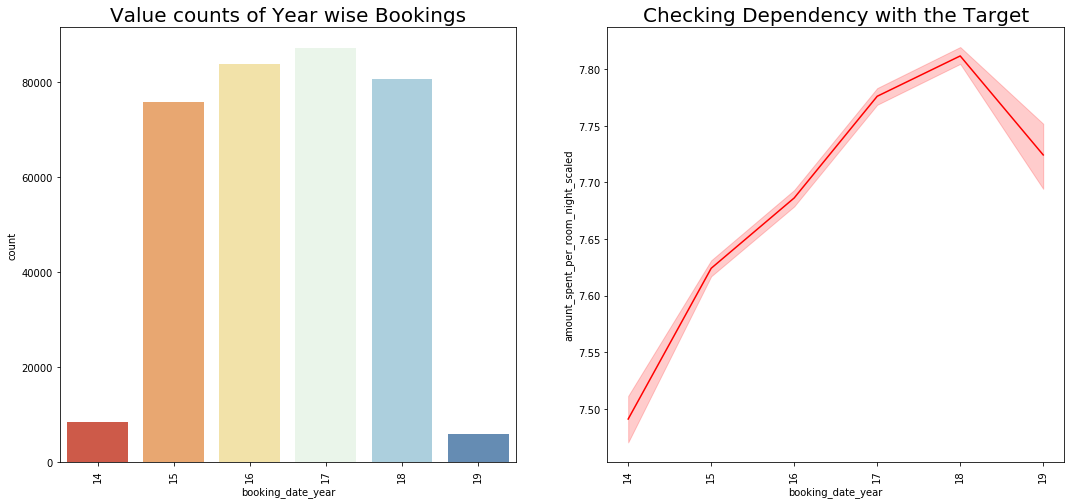

In [26]:
# analysis of booking year

# counting the values of types of reservation status
plt.rcParams['figure.figsize'] = (18, 8)
plt.subplot(1, 2, 1)
sns.countplot(train['booking_date_year'], palette = 'RdYlBu')
plt.title('Value counts of Year wise Bookings', fontsize = 20)
plt.xticks(rotation = 90)

# checking dependency with the target variable
plt.subplot(1, 2, 2)
sns.lineplot(train['booking_date_year'], y_train, color = 'red')
plt.title('Checking Dependency with the Target', fontsize = 20)
plt.xticks(rotation = 90)

plt.show()

In [27]:
# clearly visible that 18 ->17 ->19...
# target encoding for the booking year

train['booking_date_year'].replace((14, 15, 16, 17, 18, 19), (1, 2, 3, 5, 6, 4), inplace = True)

train['booking_date_year'].value_counts()

test['booking_date_year'].replace((14, 15, 16, 17, 18, 19), (1, 2, 3, 5, 6, 4), inplace = True)

test['booking_date_year'].value_counts()

5    37570
3    36047
6    34656
2    32444
1     3561
4     2487
Name: booking_date_year, dtype: int64

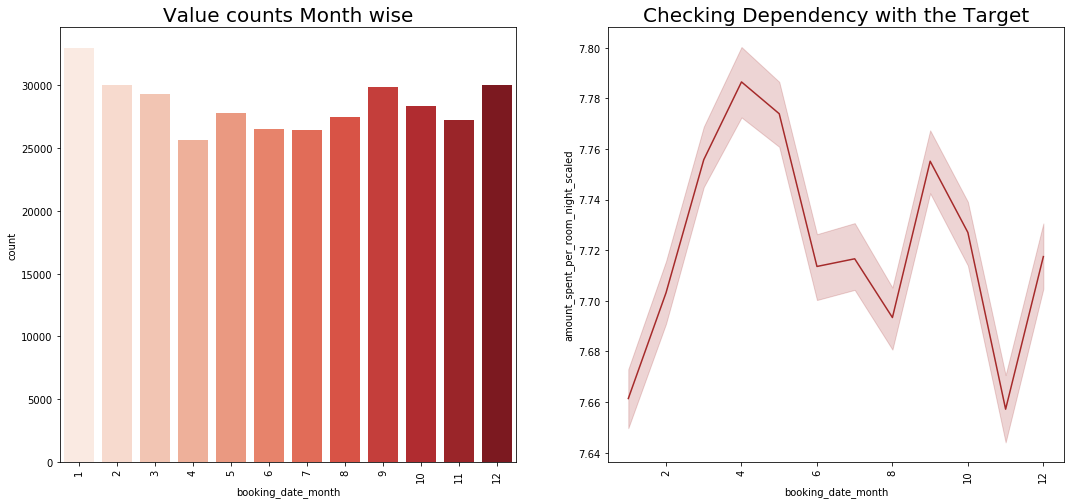

In [28]:
# analysis of booking month

# counting the values of monthly wise
plt.rcParams['figure.figsize'] = (18, 8)
plt.subplot(1, 2, 1)
sns.countplot(train['booking_date_month'], palette = 'Reds')
plt.title('Value counts Month wise', fontsize = 20)
plt.xticks(rotation = 90)

# checking dependency with the target variable
plt.subplot(1, 2, 2)
sns.lineplot(train['booking_date_month'], y_train, color = 'brown')#, palette = 'PRGn')
plt.title('Checking Dependency with the Target', fontsize = 20)
plt.xticks(rotation = 90)

plt.show()

In [29]:
# target encoding for booking month
# i have made some groups according to the graph
# most busy month -march, april, then september and may, then december, october, august, june, july, and at last february, november and January

train['booking_date_month'].replace((1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12), (1, 1, 4, 4, 3, 2, 2, 2, 3, 2, 1, 2), inplace = True)

train['booking_date_month'].value_counts()

test['booking_date_month'].replace((1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12), (1, 1, 4, 4, 3, 2, 2, 2, 3, 2, 1, 2), inplace = True)

test['booking_date_month'].value_counts()

2    59592
1    38746
3    24634
4    23793
Name: booking_date_month, dtype: int64

In [30]:
# target encoding for the checkin year

train['checkin_date_year'].replace((12, 14, 15, 16, 17,18,19), (1, 2, 3, 4, 5, 6, 6), inplace = True)

train['checkin_date_year'].value_counts()

test['checkin_date_year'].replace((12, 14, 15, 16, 17,18,19), (1, 2, 3, 4, 5, 6, 6), inplace = True)

test['checkin_date_year'].value_counts()

6    41325
5    37921
4    35462
3    32055
1        2
Name: checkin_date_year, dtype: int64

In [31]:
# target encoding for checkin month
# I have made some groups according to the graph
# most busy month -march, april, then september and may, then december, october, august, june, july, and at last february, november and January

train['checkin_date_month'].replace((1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12), (1, 1, 4, 4, 3, 2, 2, 2, 3, 2, 1, 2), inplace = True)

train['checkin_date_month'].value_counts()

test['checkin_date_month'].replace((1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12), (1, 1, 4, 4, 3, 2, 2, 2, 3, 2, 1, 2), inplace = True)

test['checkin_date_month'].value_counts()

2    58203
1    39352
4    25485
3    23725
Name: checkin_date_month, dtype: int64

In [32]:
# target encoding for the checkout year

train['checkout_date_year'].replace((12, 14, 15, 16, 17, 18, 19), (1, 2, 3, 4, 5, 6, 6), inplace = True)

train['checkout_date_year'].value_counts()

test['checkout_date_year'].replace((12, 14, 15, 16, 17, 18, 19), (1, 2, 3, 4, 5, 6, 6), inplace = True)

test['checkout_date_year'].value_counts()

6    41662
5    37896
4    35424
3    31781
1        2
Name: checkout_date_year, dtype: int64

In [33]:
# target encoding for checkin month
# I have made some groups according to the graph
# let's encode 12, 5 as 3
# let's encode 6, 4, 8, 10, 1 as 2 and,
# let's encode 2, 7, 3, 11, 9 with 1

train['checkout_date_month'].replace((1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12), (2, 1, 1, 2, 3, 3, 1, 2, 1, 2, 1, 3), inplace = True)

train['checkout_date_month'].value_counts()

test['checkout_date_month'].replace((1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12), (2, 1, 1, 2, 3, 3, 1, 2, 1, 2, 1, 3), inplace = True)

test['checkout_date_month'].value_counts()

1    58666
2    50114
3    37985
Name: checkout_date_month, dtype: int64

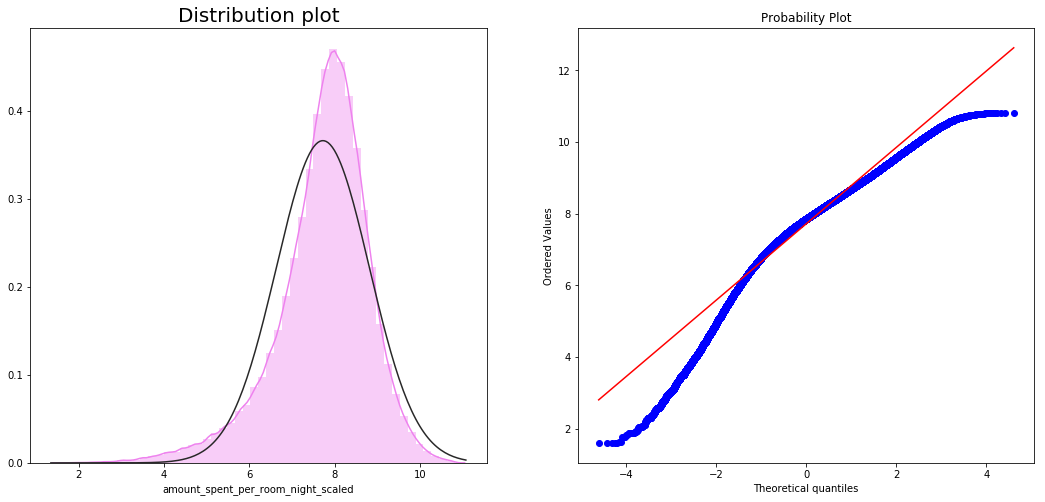

In [34]:
# let's check the distribution of y_train, the target variable

from scipy import stats
from scipy.stats import norm

plt.subplot(1, 2, 1)
sns.distplot(y_train, color = 'violet', fit = norm)
plt.title('Distribution plot', fontsize = 20)

plt.subplot(1, 2, 2)
stats.probplot(y_train, plot = plt)
plt.show()

In [35]:
# taking log
train['numberofadults'] = np.log1p(train['numberofadults'])
train['numberofchildren'] = np.log1p(train['numberofchildren'])
train['resort_type_code'] = np.log1p(train['resort_type_code'])
train['room_type_booked_code'] = np.log1p(train['room_type_booked_code'])
train['roomnights'] = np.log1p(train['roomnights'])
train['state_code_residence'] = np.log1p(train['state_code_residence'])
train['total_pax'] = np.log1p(train['total_pax'])

test['numberofadults'] = np.log1p(test['numberofadults'])
test['numberofchildren'] = np.log1p(test['numberofchildren'])
test['resort_type_code'] = np.log1p(test['resort_type_code'])
test['room_type_booked_code'] = np.log1p(test['room_type_booked_code'])
test['roomnights'] = np.log1p(test['roomnights'])
test['state_code_residence'] = np.log1p(test['state_code_residence'])
test['total_pax'] = np.log1p(test['total_pax'])

In [36]:
X=train[['channel_code', 'main_product_code', 'numberofadults',
       'numberofchildren', 'persontravellingid', 'resort_region_code',
       'resort_type_code', 'room_type_booked_code', 'roomnights',
       'season_holidayed_code', 'state_code_residence', 'state_code_resort',
       'total_pax', 'member_age_buckets', 'booking_type_code', 'cluster_code',
       'reservationstatusid_code', 'resort_id','booking_date_month',
       'booking_date_year', 'checkin_date_month', 'checkin_date_year',
       'checkout_date_month', 'checkout_date_year','no. of days']]

Y = train['amount_spent_per_room_night_scaled']

x_test=test[['channel_code', 'main_product_code', 'numberofadults',
       'numberofchildren', 'persontravellingid', 'resort_region_code',
       'resort_type_code', 'room_type_booked_code', 'roomnights',
       'season_holidayed_code', 'state_code_residence', 'state_code_resort',
       'total_pax', 'member_age_buckets', 'booking_type_code', 'cluster_code',
       'reservationstatusid_code', 'resort_id','booking_date_month',
       'booking_date_year', 'checkin_date_month', 'checkin_date_year',
       'checkout_date_month', 'checkout_date_year','no. of days']]

In [37]:
lgb_params = {
    "objective" : "regression",
    "metric" : "rmse",
    "boosting" : 'gbdt',
    "max_bin" : 10,            # large value for better accuracy
    "learning_rate" : 0.01,     # use small value for better accuracy
#     "num_iterations" : 100,    # large value
    "num_leaves" : 13,        # use large
    "max_depth" : -1,
    "min_data_in_leaf":0,
    "bagging_speed" : 1234,
    "verbosity" : 1,
    "lambda_l2" : 5.0,
    "seed" : 1234,
    "drop_rate" : 0.5,
}

In [38]:
from sklearn.preprocessing import StandardScaler

# Apply standardization
sc = StandardScaler()
X = sc.fit_transform(X)
x_test = sc.transform(x_test)

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/arya/.local/lib/python3.5/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  


In [39]:
# finding the skewed features

from scipy.stats import skew

# getting the numerical features
numerical_features = train.dtypes[train.dtypes != 'object'].index

# extracting the skewed features
skewed_features = train[numerical_features].apply(lambda x: skew(x.dropna())).sort_values(ascending = False)

# converting the feautures into a dataframe
skewness = pd.DataFrame({'skew': skewed_features})

# let's check the skewess in the data
skewness.head(10)

,skew
numberofchildren,28.519452
numberofadults,12.150308
no. of days,10.696616
persontravellingid,5.056162
total_pax,4.872165
booking_type_code,2.278763
roomnights,1.602066
booking_date_month,0.466237
checkin_date_month,0.451133
checkout_date_month,0.254834


In [40]:
# applying box-cox transformations

skewness = skewness[abs(skewness > 0.8)]
print("There are {} skewed features to box-cox transform".format(skewness.shape[0]))

# importing box-cox
from scipy.special import boxcox1p

skewed_features = skewness.index

lam = 0.15
for feat in skewed_features:
    train[feat] += 1
    train[feat] = boxcox1p(train[feat], lam)
  
train[skewed_features] = np.log1p(train[skewed_features])

/usr/local/lib/python3.5/dist-packages/pandas/core/computation/check.py:19: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.6.1

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


There are 26 skewed features to box-cox transform


In [41]:
# getting the numerical features
numerical_features = test.dtypes[test.dtypes != 'object'].index

# extracting the skewed features
skewed_features = test[numerical_features].apply(lambda x: skew(x.dropna())).sort_values(ascending = False)

# converting the feautures into a dataframe
skewness = pd.DataFrame({'skew': skewed_features})

# let's check the skewess in the data
skewness.head(10)

,skew
numberofchildren,28.092052
numberofadults,12.183520
no. of days,10.844564
persontravellingid,5.075193
total_pax,4.933117
booking_type_code,2.290738
roomnights,1.624281
booking_date_month,0.465426
checkin_date_month,0.452536
checkout_date_month,0.258377


In [42]:
# applying box-cox transformations on test

skewness = skewness[abs(skewness > 0.8)]
print("There are {} skewed features to box-cox transform".format(skewness.shape[0]))

# importing box-cox
from scipy.special import boxcox1p

skewed_features = skewness.index

lam = 0.15
for feat in skewed_features:
    test[feat] += 1
    test[feat] = boxcox1p(train[feat], lam)
  
test[skewed_features] = np.log1p(train[skewed_features])

There are 24 skewed features to box-cox transform


In [43]:
kf = KFold(n_splits=15,shuffle=True,random_state=31)

all_preds = []
for t,v in kf.split(X,Y):
    x_train, x_valid, y_train, y_valid = X[t], X[v], Y.iloc[t], Y.iloc[v]
    lgb_train = lgb.Dataset(x_train,
                            label=y_train,)
#                            categorical_feature=['channel_code', 'main_product_code', 'numberofadults',
#                                                 'numberofchildren', 'persontravellingid', 'resort_region_code',
#                                                 'resort_type_code', 'room_type_booked_code', 'roomnights',
#                                                 'season_holidayed_code', 'state_code_residence', 'state_code_resort',
#                                                 'total_pax', 'member_age_buckets', 'booking_type_code', 'cluster_code',
#                                                 'reservationstatusid_code', 'resort_id','booking_date_month',
#                                                 'booking_date_year', 'checkin_date_month', 'checkin_date_year',
#                                                 'checkout_date_month', 'checkout_date_year','no. of days'])
    lgb_valid = lgb.Dataset(x_valid,
                            label=y_valid,)
#                             categorical_feature=['channel_code', 'main_product_code', 'numberofadults',
#                                                 'numberofchildren', 'persontravellingid', 'resort_region_code',
#                                                 'resort_type_code', 'room_type_booked_code', 'roomnights',
#                                                 'season_holidayed_code', 'state_code_residence', 'state_code_resort',
#                                                 'total_pax', 'member_age_buckets', 'booking_type_code', 'cluster_code',
#                                                 'reservationstatusid_code', 'resort_id','booking_date_month',
#                                                 'booking_date_year', 'checkin_date_month', 'checkin_date_year',
#                                                 'checkout_date_month', 'checkout_date_year','no. of days'])
    evals_result = {}
    lgb_clf = lgb.train(lgb_params,
                        lgb_train,
                        100000,
                        valid_sets = [lgb_train,lgb_valid],
                        early_stopping_rounds=3000,
                        verbose_eval = 1000,
                        evals_result = evals_result)
    all_preds.append(lgb_clf.predict(x_test))

Training until validation scores don't improve for 3000 rounds.
[1000]	training's rmse: 0.161328	valid_1's rmse: 0.15981
[2000]	training's rmse: 0.16073	valid_1's rmse: 0.159561
[3000]	training's rmse: 0.160361	valid_1's rmse: 0.159448
[4000]	training's rmse: 0.16005	valid_1's rmse: 0.159364
[5000]	training's rmse: 0.159769	valid_1's rmse: 0.159279


KeyboardInterrupt: 

In [ ]:
imp = lgb_clf.feature_importance()
fet = lgb_clf.feature_name()
sns.barplot(x=imp,y=fet)

In [ ]:
all_preds = np.vstack(all_preds)

In [ ]:
preds = np.mean(all_preds,axis=0)

In [ ]:
preds.shape

In [ ]:
submission = pd.DataFrame()
submission['reservation_id']=test_original['reservation_id']
submission['amount_spent_per_room_night_scaled'] = preds
submission

In [ ]:
submission.to_csv('combine_with_skew_with_log.csv',index=False)